Improved at step 4: best = 2583


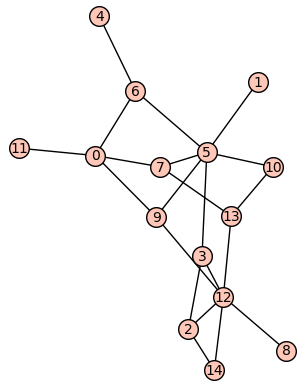

Improved at step 5: best = 2461


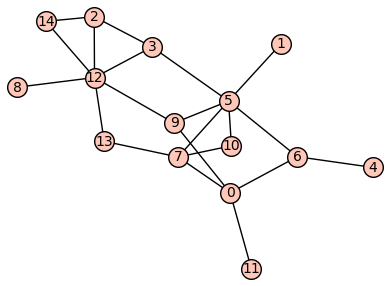

Improved at step 6: best = 2235


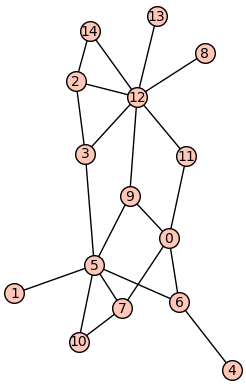

Improved at step 8: best = 2158


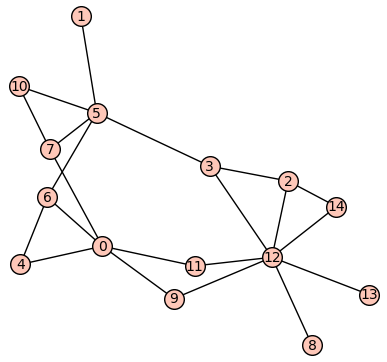

Improved at step 16: best = 2045


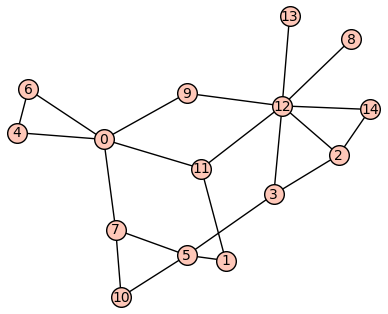

Improved at step 17: best = 1308


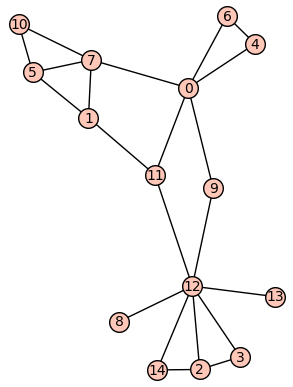

Improved at step 19: best = 1256


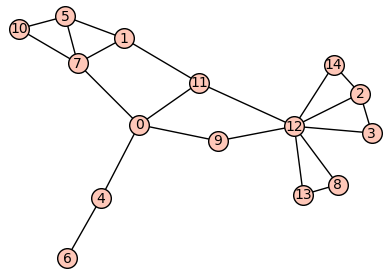

Improved at step 24: best = 1108


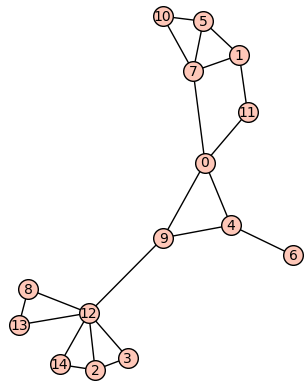

Improved at step 26: best = 1024


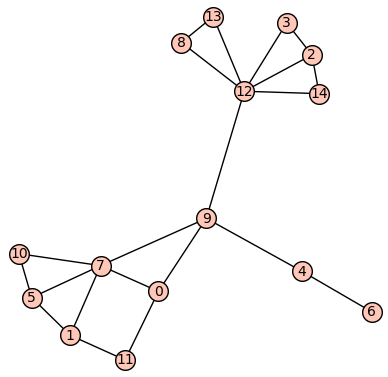

Improved at step 28: best = 879


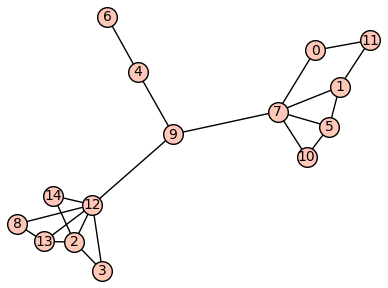

Improved at step 33: best = 854


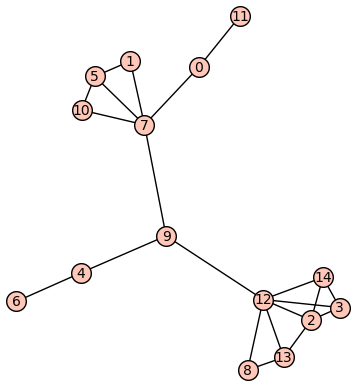

Improved at step 58: best = 823


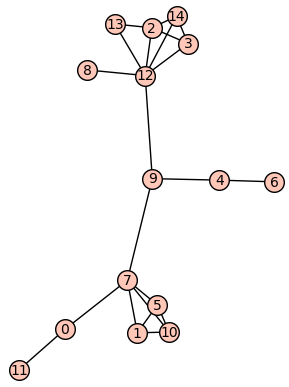

Improved at step 75: best = 782


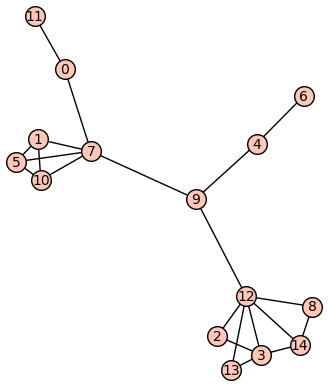

Improved at step 122: best = 754


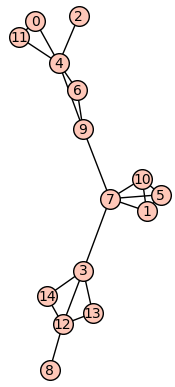

Improved at step 148: best = 672


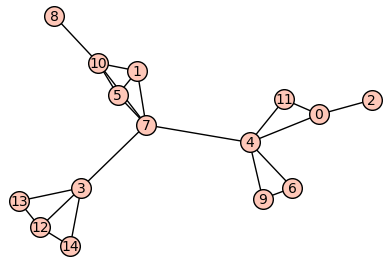

Improved at step 169: best = 637


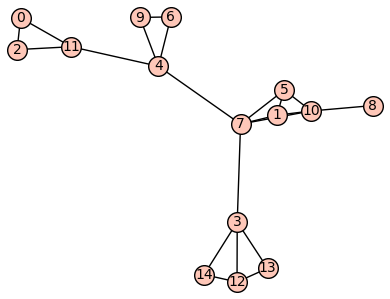

Improved at step 463: best = 606


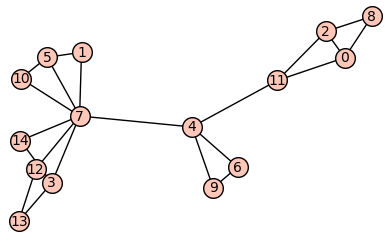

Improved at step 670: best = 579


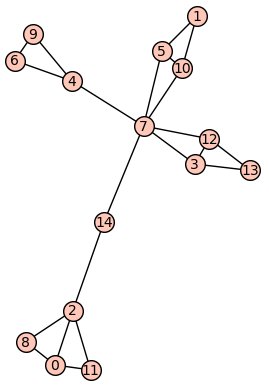

Improved at step 723: best = 553


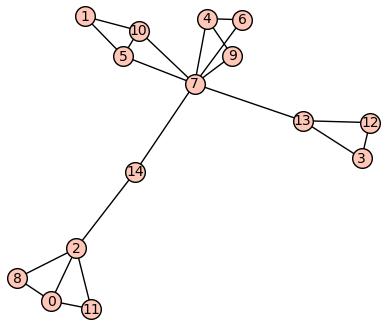

Improved at step 1088: best = 502


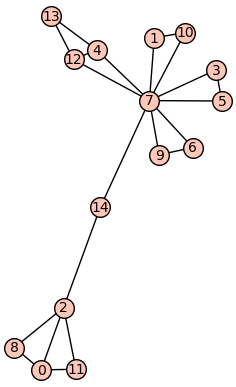

Improved at step 3133: best = 479


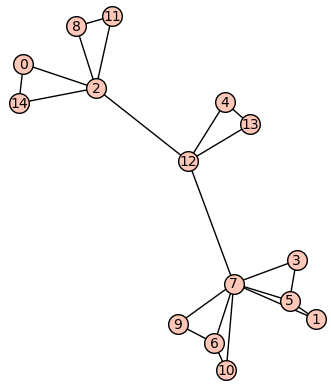

Best: 479


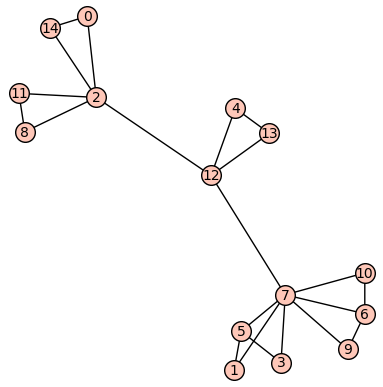

Ali je PTC graf False


In [30]:
import random as pyrandom
from sage.all import *

# ============================================================
#   Helper: all simple paths + subpath number
# ============================================================

def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for nei in G.neighbors(start):
        if nei not in visited:
            newp = all_simple_paths(G, nei, end, visited)
            paths.extend(newp)
    return paths

def subpath_number(G):
    V = G.vertices()
    total = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            total += len(all_simple_paths(G, V[i], V[j]))
    return total

# ============================================================
#   Mutacija grafa
# ============================================================

def mutate_graph(G):
    H = G.copy()

    edges = list(H.edges())
    non_edges = [(u, v) for u in H.vertices()
                 for v in H.vertices()
                 if u < v and not H.has_edge(u, v)]

    if not edges or not non_edges:
        return H

    e_remove = pyrandom.choice(edges)
    H.delete_edge(e_remove)

    e_add = pyrandom.choice(non_edges)
    H.add_edge(e_add)

    if not H.is_connected():
        return G

    return H

# ============================================================
#   Naključni povezan graf G(n, m)
# ============================================================
def random_connected_graph(n, m):
    while True:
        G = graphs.RandomGNM(n, m)
        if G.is_connected():
            return G

# ============================================================
#   Preverjanje PTC
# ============================================================
def is_ptc(G):
    # mora biti povezan
    if not G.is_connected():
        return False

    # blok-komponente in presečišča
    blocks, cut_vertices = G.blocks_and_cut_vertices()

    # shranimo samo nenetrivialne bloke (vsaj 2 vozlišči)
    nontrivial_blocks = [Bl for Bl in blocks if len(Bl) >= 2]
    B = len(nontrivial_blocks)

    if B < 2:
        return False

    # 1) vsak nenetrivialen blok mora biti trikotnik (C3)
    triangular_idx = []
    for i, Bl in enumerate(nontrivial_blocks):
        sub = G.subgraph(Bl)
        if sub.order() == 3 and sub.size() == 3:
            triangular_idx.append(i)
        else:
            # če je kakšen blok, ki ni trikotnik, ni PTC
            return False

    k = len(triangular_idx)
    if k < 2:
        return False

    # 2) zgradimo block-graf med trikotniki
    adj = {i: [] for i in triangular_idx}

    for i in triangular_idx:
        for j in triangular_idx:
            if j <= i:
                continue
            inter = set(nontrivial_blocks[i]).intersection(nontrivial_blocks[j])
            if len(inter) > 1:
                # dva trikotnika ne smeta deliti več kot enega vozlišča
                return False
            if len(inter) == 1:
                adj[i].append(j)
                adj[j].append(i)

    # 3) preverimo, da je block-graf pot: stopnje ≤2,
    #    točno dva trikotnika stopnje 1, ostali stopnje 2
    degrees = [len(adj[i]) for i in triangular_idx]

    if any(d == 0 or d > 2 for d in degrees):
        return False

    ends = sum(1 for d in degrees if d == 1)
    mids = sum(1 for d in degrees if d == 2)

    if ends != 2:
        return False
    if ends + mids != k:
        return False

    # 4) preverimo še povezavnost med trikotniki (da je res ena sama veriga)
    # BFS po block-grafu
    start = triangular_idx[0]
    visited = set([start])
    stack = [start]

    while stack:
        v = stack.pop()
        for w in adj[v]:
            if w not in visited:
                visited.add(w)
                stack.append(w)

    if len(visited) != k:
        return False

    return True


# ============================================================
#   Simulated annealing + STOP WHEN PTC FOUND
# ============================================================

def simulated_annealing(n, m, direction,
                        T_start=25.0, T_end=0.001,
                        cooling=0.9995, max_steps=4000):

    # začetni graf
    G = random_connected_graph(n, m)

    best_G = G.copy()
    best_score = subpath_number(G)

    current_G = G.copy()
    current_score = best_score

    T = T_start

    for step in range(max_steps):

        new_G = mutate_graph(current_G)
        new_score = subpath_number(new_G)

        # izračun delte
        if direction == "min":
            delta = new_score - current_score
        else:  # direction == "max"
            delta = current_score - new_score

        # SA sprejem
        if delta < 0:
            current_G = new_G
            current_score = new_score
        else:
            if pyrandom.random() < exp(-delta / T):
                current_G = new_G
                current_score = new_score

        # ===========================
        #   PREVERJANJE IZBOLJŠAVE
        # ===========================
        improved = False

        if direction == "min":
            if current_score < best_score:
                improved = True
        else: # direction == "max"
            if current_score > best_score:
                improved = True

        if improved:
            best_score = current_score
            best_G = current_G.copy()

            print(f"Improved at step {step}: best = {best_score}")
            best_G.show()

            # -------------------------------
            #   PTC STOP CONDITION (MIN ONLY)
            # -------------------------------
            if direction == "min" and is_ptc(best_G):
                print("PTC FOUND → stopping SA early!")
                return best_G, best_score

        # hlajenje
        T *= cooling
        if T < T_end:
            break

    return best_G, best_score

# ============================================================
#   TEST
# ============================================================

n = 15
c = 7
m = c + n - 1
direction = "min"

best_graph, best_value = simulated_annealing(n, m, direction)
print("Best:", best_value)
best_graph.show()
print("Ali je PTC graf", is_ptc(best_graph))


In [ ]:
# kle je isto samo da je zanka po stevilu povezav
import random as pyrandom
from sage.all import *

# ============================================================
#   Helper: all simple paths + subpath number
# ============================================================

def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for nei in G.neighbors(start):
        if nei not in visited:
            newp = all_simple_paths(G, nei, end, visited)
            paths.extend(newp)
    return paths

def subpath_number(G):
    V = G.vertices()
    total = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            total += len(all_simple_paths(G, V[i], V[j]))
    return total


# ============================================================
#   Mutacija grafa
# ============================================================

def mutate_graph(G):
    H = G.copy()

    edges = list(H.edges())
    non_edges = [(u, v) for u in H.vertices()
                 for v in H.vertices()
                 if u < v and not H.has_edge(u, v)]

    if not edges or not non_edges:
        return H

    e_remove = pyrandom.choice(edges)
    H.delete_edge(e_remove)

    e_add = pyrandom.choice(non_edges)
    H.add_edge(e_add)

    if not H.is_connected():
        return G

    return H


# ============================================================
#   Naključni povezan graf G(n, m)
# ============================================================

def random_connected_graph(n, m):
    while True:
        G = graphs.RandomGNM(n, m)
        if G.is_connected():
            return G


# ============================================================
#   Preverjanje PTC
# ============================================================

def is_ptc(G):
    if not G.is_connected():
        return False

    blocks, cut_vertices = G.blocks_and_cut_vertices()
    nontrivial = [Bl for Bl in blocks if len(Bl) >= 2]

    if len(nontrivial) < 2:
        return False

    # vsi nenetrivialni bloki morajo biti trikotniki
    for Bl in nontrivial:
        sub = G.subgraph(Bl)
        if not (sub.order() == 3 and sub.size() == 3):
            return False

    idx = list(range(len(nontrivial)))
    adj = {i: [] for i in idx}

    # povezave med trikotniki
    for i in idx:
        for j in idx:
            if j <= i:
                continue
            inter = set(nontrivial[i]).intersection(nontrivial[j])
            if len(inter) > 1:
                return False
            if len(inter) == 1:
                adj[i].append(j)
                adj[j].append(i)

    deg = [len(adj[i]) for i in idx]

    if any(d == 0 or d > 2 for d in deg):
        return False

    ends = sum(1 for d in deg if d == 1)
    mids = sum(1 for d in deg if d == 2)

    if ends != 2:
        return False
    if ends + mids != len(idx):
        return False

    # preveri povezavnost verige trikotnikov
    start = idx[0]
    visited = {start}
    stack = [start]

    while stack:
        v = stack.pop()
        for w in adj[v]:
            if w not in visited:
                visited.add(w)
                stack.append(w)

    return len(visited) == len(idx)


# ============================================================
#   Simulated annealing (BREZ izrisovanja vmesnih izboljšav)
# ============================================================

def simulated_annealing(n, m, direction,
                        T_start=5.0, T_end=0.01,
                        cooling=0.999, max_steps=5000):

    G = random_connected_graph(n, m)

    best_G = G.copy()
    best_score = subpath_number(G)

    current_G = G.copy()
    current_score = best_score

    T = T_start

    for step in range(max_steps):

        new_G = mutate_graph(current_G)
        new_score = subpath_number(new_G)

        if direction == "min":
            delta = new_score - current_score
        else:
            delta = current_score - new_score

        if delta < 0:
            current_G, current_score = new_G, new_score
        else:
            if pyrandom.random() < exp(-delta / T):
                current_G, current_score = new_G, new_score

        # preveri izboljšavo
        improved = (
            (direction == "min" and current_score < best_score) or
            (direction == "max" and current_score > best_score)
        )

        if improved:
            best_score = current_score
            best_G = current_G.copy()

        T *= cooling
        if T < T_end:
            break

    return best_G, best_score


# ============================================================
#   ZANKA PO INTERVALU m
# ============================================================

n = 8
m_start = 11
m_end   = 16
direction = "min"   # ali "max"

results = []

for m in range(m_start, m_end + 1):
    print(f"\n=== n={n}, m={m} ===")
    best_graph, best_value = simulated_annealing(n, m, direction)
    print(f"Optimalni p_n(G) = {best_value}")
    results.append((m, best_value, best_graph))


# ------------------------------------------------------------
#   Če želiš izrisati samo končne grafe:
# ------------------------------------------------------------

for m, val, G in results:
    print(f"\nKončni graf za m={m}, p_n(G)={val}")
    G.show()


In [31]:
import random as pyrandom
from sage.all import *
import pandas as pd

# ============================================================
#   Subpath number
# ============================================================

def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for nei in G.neighbors(start):
        if nei not in visited:
            newp = all_simple_paths(G, nei, end, visited)
            paths.extend(newp)
    return paths


def subpath_number(G):
    V = G.vertices()
    total = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            total += len(all_simple_paths(G, V[i], V[j]))
    return total


# ============================================================
#   Mutacija grafa
# ============================================================

def mutate_graph(G):
    H = G.copy()

    edges = list(H.edges())
    non_edges = [(u, v) for u in H.vertices()
                 for v in H.vertices()
                 if u < v and not H.has_edge(u, v)]

    if not edges or not non_edges:
        return H

    e_remove = pyrandom.choice(edges)
    H.delete_edge(e_remove)

    e_add = pyrandom.choice(non_edges)
    H.add_edge(e_add)

    if not H.is_connected():
        return G

    return H


# ============================================================
#   Expand graph (from n-1 to n)
# ============================================================

def expand_graph(G_old, n_new, m_target, direction):
    """
    Razširi graf G_old (z n-1 vozlišči) na graf z n vozlišči in m_target robovi.
    """
    H = Graph(G_old)

    # novo vozlišče naj ima label = max+1 (ne zaupamo n_new)
    new_v = max(H.vertices()) + 1
    H.add_vertex(new_v)

    # osnovna povezava za povezanost
    H.add_edge(0, new_v)

    while H.size() < m_target:

        if direction == "min":
            # minimalna invazivnost: najprej povezuj new_v z različnimi vozlišči
            for v in H.vertices():
                if v != new_v and not H.has_edge(v, new_v):
                    H.add_edge(v, new_v)
                    break
            # če še manjka, dodaj poljuben ne-rob
            if H.size() < m_target:
                for u in H.vertices():
                    for v in H.vertices():
                        if u < v and not H.has_edge(u, v):
                            H.add_edge(u, v)
                            break
                    if H.size() == m_target:
                        break

        else:
            # maksimalna invazivnost: new_v močno poveži
            for v in H.vertices():
                if v != new_v and not H.has_edge(new_v, v):
                    H.add_edge(new_v, v)
                    break
            if H.size() < m_target:
                for u in H.vertices():
                    for v in H.vertices():
                        if u < v and not H.has_edge(u, v):
                            H.add_edge(u, v)
                            break
                    if H.size() == m_target:
                        break

    return H


# ============================================================
#   Inicializacija iz optimalnih grafov n ≤ 8 (fleksibilno μ)
# ============================================================

def load_optimal_graph_flexible(n_old, mu_desired, direction):
    """
    Vrne optimalni graf za n_old in μ_old čim bližje mu_desired.
    Če μ_desired ne obstaja, uporabi največji razpoložljivi μ.
    """

    df = pd.read_csv("rezultati_subpath_grafi_enolicni.csv")

    n_old = int(n_old)
    mu_desired = int(mu_desired)

    subset = df[df["n"] == n_old].copy()
    if len(subset) == 0:
        raise ValueError(f"No stored optimal graphs for n={n_old}")

    available_mu = sorted(int(x) for x in subset["µ(G)"].unique())

    # izberi μ_old
    if mu_desired in available_mu:
        mu_old = mu_desired
    else:
        mu_old = max(available_mu)

    row = subset[subset["µ(G)"] == mu_old].reset_index(drop=True)
    if len(row) == 0:
        raise ValueError(f"No optimal graph exists for n={n_old}, μ={mu_old}")

    if direction == "min":
        g6 = row.loc[0, "graph6_min"]
    else:
        g6 = row.loc[0, "graph6_max"]

    return Graph(g6)


# ============================================================
#   PTC check
# ============================================================

def is_ptc(G):
    if not G.is_connected():
        return False
    blocks, cut_vertices = G.blocks_and_cut_vertices()
    nontrivial = [Bl for Bl in blocks if len(Bl) >= 2]
    if len(nontrivial) < 2:
        return False
    tri = []
    for i, Bl in enumerate(nontrivial):
        sub = G.subgraph(Bl)
        if sub.order() == 3 and sub.size() == 3:
            tri.append(i)
        else:
            return False
    k = len(tri)
    if k < 2:
        return False
    adj = {i: [] for i in tri}
    for i in tri:
        for j in tri:
            if j <= i:
                continue
            inter = set(nontrivial[i]).intersection(nontrivial[j])
            if len(inter) > 1:
                return False
            if len(inter) == 1:
                adj[i].append(j)
                adj[j].append(i)
    deg = [len(adj[i]) for i in tri]
    if any(d == 0 or d > 2 for d in deg):
        return False
    if sum(d == 1 for d in deg) != 2:
        return False
    start = tri[0]
    vis = {start}
    stack = [start]
    while stack:
        v = stack.pop()
        for w in adj[v]:
            if w not in vis:
                vis.add(w)
                stack.append(w)
    return len(vis) == k


# ============================================================
#   Simulated annealing WITH advanced initialization
# ============================================================

def simulated_annealing(n, m, direction,
                        T_start=25.0, T_end=0.001,
                        cooling=0.9995, max_steps=4000):

    n = int(n)
    m = int(m)
    mu = m - n + 1

    if mu >= 1:
    # želimo μ_old = μ + 1
        G_old = load_optimal_graph_flexible(
            n_old=int(n-1),
            mu_desired=int(mu+1),
            direction=direction
        )
    else:
        # mu = 0 → drevo; vzemi μ_old = 1
        G_old = load_optimal_graph_flexible(
            n_old=int(n-1),
            mu_desired=1,
            direction=direction
        )


    G = expand_graph(G_old, n_new=n, m_target=m, direction=direction)

    best_G = G.copy()
    best_score = subpath_number(G)

    current_G = G.copy()
    current_score = best_score

    T = T_start

    for step in range(max_steps):
        new_G = mutate_graph(current_G)
        new_score = subpath_number(new_G)

        if direction == "min":
            delta = new_score - current_score
        else:
            delta = current_score - new_score

        if delta < 0:
            current_G = new_G
            current_score = new_score
        else:
            if pyrandom.random() < exp(-delta/T):
                current_G = new_G
                current_score = new_score

        improved = ((direction == "min" and current_score < best_score) or
                    (direction == "max" and current_score > best_score))

        if improved:
            best_G = current_G.copy()
            best_score = current_score

            if direction == "min" and is_ptc(best_G):
                return best_G, best_score

        T *= cooling
        if T < T_end:
            break

    return best_G, best_score


# ============================================================
#   EXAMPLE RUN
# ============================================================

n = 9
m = 8   # μ = m - n + 1 = 0
direction = "min"

best_graph, best_value = simulated_annealing(n, m, direction)

print("Best value:", best_value)
print("PTC:", is_ptc(best_graph))
best_graph.show()
print("graph6:", best_graph.graph6_string())


KeyError: 0